# Edit Input Image to Exclude Background Stars

This notebook can be used to edit an input image in the case that there are background star PSFs in the **non-guider point of view** (i.e in a NIRCam image) that MAGIC thinks are associated with the guide star. Here, as much as possible, we will remove the problematic PSFs so that the guide star counts rates are not also applied to the non-guide star PSF(s).

### Imports

In [1]:
import copy

from astropy.io import fits
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

# Set a new colormap so that values <=0 are not white
my_cmap = copy.copy(matplotlib.cm.get_cmap('viridis'))
my_cmap.set_bad((0, 0, 0), .75)

### Functions 

In [2]:
def set_lower_limit(coordinate, window, minimum_value=0):
    """
    For a single coordinate position (i.e x or y) return the lower limit of a window given the window size and 
    the absolute minimum value of the window position
    """
    lower_lim = coordinate-window//2
    if lower_lim < minimum_value:
        lower_lim = minimum_value
    return lower_lim

def set_upper_limit(coordinate, window, maximum_value=2048):
    """
    For a single coordinate position (i.e x or y) return the upper limit of a window given the window size and 
    the absolute maximum value of the window position
    """
    upper_lim = coordinate+window//2
    if upper_lim > maximum_value:
        upper_lim = maximum_value
    return upper_lim

### Set basic input values - User should change these values

In [3]:
# Input image and paths
image = '/Users/kbrooks/Documents/tel/FGS/sample_images/jw01153001001_02101_00001_nrca3_cal.fits'  # path to input image

### Check input file

In [4]:
hdu = fits.open(image)
hdu.info()

Filename: /Users/kbrooks/Documents/tel/FGS/sample_images/jw01153001001_02101_00001_nrca3_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     258   ()      
  1  SCI           1 ImageHDU        85   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2048, 2048)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [16869B]   


In [5]:
image_data = hdu[1].data  # You may have to change the extension from 1

In the sample image used for this notebook, there is a background PSF in the lower left of the sample image that is confusing MAGIC. This is the PSF that we are trying to remove.

In the following cell, you will be plotting out your image. You want to identify the location(s) of the problematic background PSF(s) either by eye-balling it in the below plot, or using DS9 to get a more accurate location.

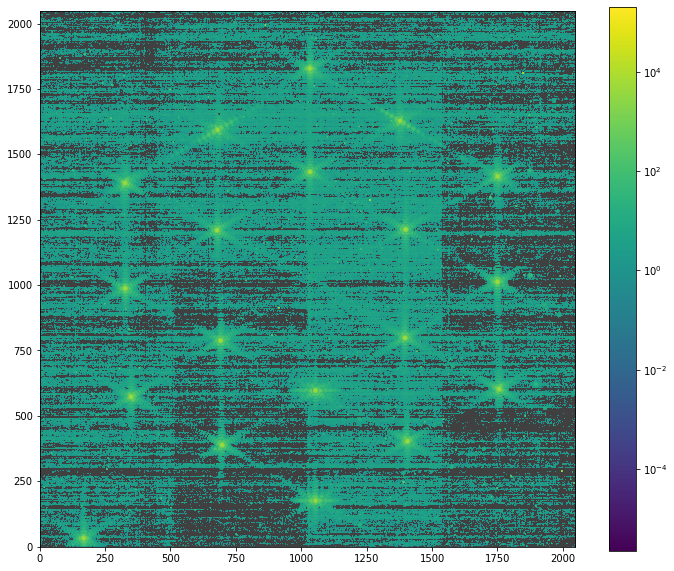

In [6]:
# Plot the input image
plt.figure(figsize=(12, 10))
plt.imshow(image_data, norm=LogNorm(), origin='lower', cmap=my_cmap) 
plt.colorbar()
plt.show()

In the cell below, for each background PSF, list its x coordinate in the `x_coords` list, and its y coordinate in the `y_coords` list. If there is only one background PSF that needs to be removed, you can follow in the formatting in the example, where only one number is given in each list.

In [7]:
# Update these coordinates based on your own image. Be sure not to choose a PSF that is part of the guide star!
# List all x and y coordinates in the x_coords and y_coords variables below
x_coords = [175, ]
y_coords = [30, ]

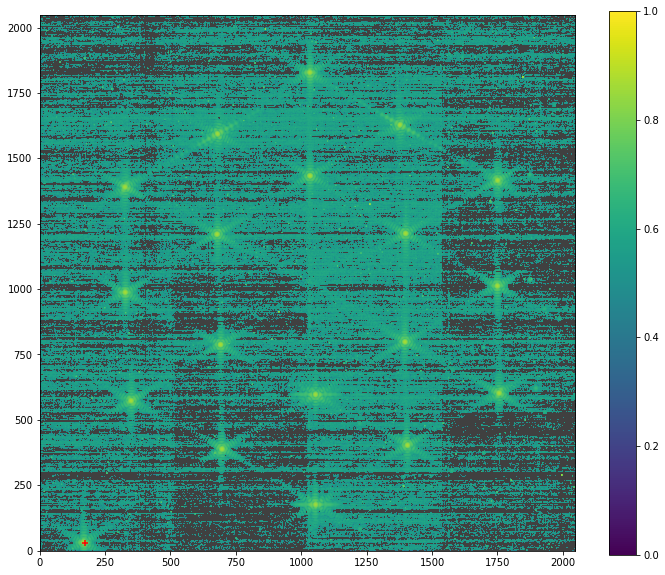

In [8]:
# Plot the input image
plt.figure(figsize=(12, 10))
plt.imshow(image_data, norm=LogNorm(), origin='lower', cmap=my_cmap) 
plt.scatter(x_coords, y_coords, c='r', marker='+')
plt.colorbar()
plt.show()

### Remove problematic PSF(s)

In [9]:
# Set the PSF count rate to zero. Since this is in the background it will be set to zero by MAGIC anyway
psf_window = 200

In [10]:
# Remove PSFs
for x, y, in zip(x_coords, y_coords):
    lower_lim_x = set_lower_limit(x, psf_window, minimum_value=0)
    upper_lim_x = set_upper_limit(x, psf_window, maximum_value=2048)

    lower_lim_y = set_lower_limit(y, psf_window, minimum_value=0)
    upper_lim_y = set_upper_limit(y, psf_window, maximum_value=2048)

    updated_image_data = image_data.copy()
    updated_image_data[lower_lim_y:upper_lim_y, lower_lim_x:upper_lim_x] = np.zeros((upper_lim_y-lower_lim_y,
                                                                                       upper_lim_x-lower_lim_x))

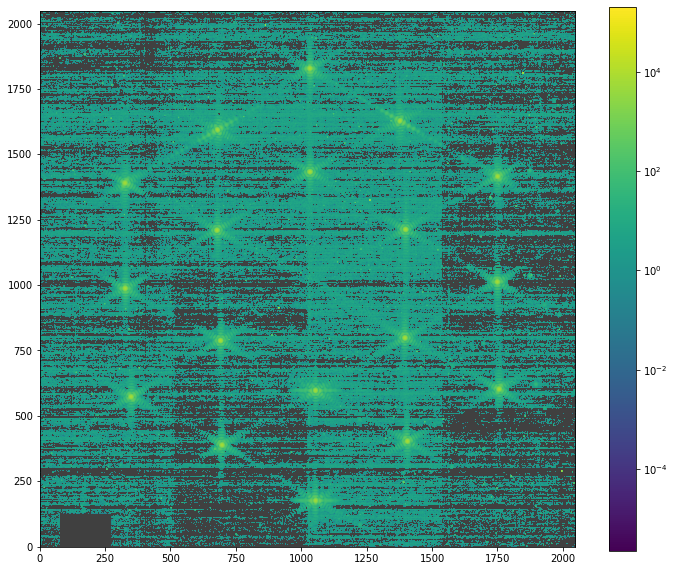

In [11]:
# Plot the input image
plt.figure(figsize=(12, 10))
plt.imshow(updated_image_data, norm=LogNorm(), origin='lower', cmap=my_cmap) 
plt.colorbar()
plt.show()

### Write out the updated input image 

In [12]:
# Create a filename that is the same, but includes 'updated_' before 'cal', assumes 'cal' is in your filename
index = image.find('cal')
outfile = f"{image[:index]}updated_{image[index:]}"

In [13]:
hdu[1].data = updated_image_data
hdu.writeto(outfile, overwrite=True)

## Now back in the MAGIC GUI:
 - Open the GUI
 - Load this new image as the input image
 - Uncheck the "Use existing converted image" button and re-run the GUI

-----

### About this Notebook:
Last updated: 7 Jan, 2022

Author: K.Brooks